In [1]:
### Loading the fluo quantity relationship data
import pandas as pd
import os
os.chdir("/data/biocomp/bahin/qPCR/qPCRquantification/")
import fluo_quantity_relationship
from fluo_quantity_relationship import *

# Gathering data
#data = fluo_quantity_relationship.gather_data()

# Filtering out pre-amplified samples
#data_not_preamp = data.loc[data.Sample.isin(not_preamplified)]

# Computing genes efficiency with different methods
#data_not_preamp, methods_comparison, well_comb_filtered = fluo_quantity_relationship.our_method(data_not_preamp, methods_comparison)
#data_not_preamp, methods_comparison = fluo_quantity_relationship.Ct_method(data_not_preamp, methods_comparison)
#data = data_not_preamp

Loading qPCR data...
Successful data extraction.


KeyboardInterrupt: 

In [5]:
import pandas as pd
import numpy as np
from dask import dataframe as dd
from dask.multiprocessing import get

def func1(row, param):
    return float(row.Val1) * param, float(row.Val1) * np.power(param, 2)

data = pd.DataFrame(np.array([["A01", 12], ["A02", 24], ["A03", 13]]), columns=["ID", "Val1"])
display(data)

#res = {"simple_mulitply" : float, "squared_multiply" : float}
#res = dict.fromkeys(range(2), float)
res = {0: float, 1: float}
print(res)

#data[["Res1", "Res2"]] = data.apply(lambda row: func1(row, 2), axis=1, result_type="expand")
df2 = dd.from_pandas(data, npartitions=2).map_partitions(
    lambda df: df.apply(lambda row: func1(row, 2), axis=1, result_type="expand"), meta=res).compute(scheduler=get)
display(df2)

,ID,Val1
0,A01,12
1,A02,24
2,A03,13


{0: <class 'float'>, 1: <class 'float'>}


,0,1
0,24.0,48.0
1,48.0,96.0
2,26.0,52.0


In [5]:
def our_method_infer_E(dataset, precision):
    ''' Infers genes efficiency from the input dataset. '''

    # Creating the wells combinations (without combinations between replicates)
    well_comb = pd.merge(dataset, dataset, on="Gene", suffixes=["_1", "_2"])
    well_comb_filtered = well_comb.loc[well_comb.Sample_1 != well_comb.Sample_2]

    # Infering Nt and E values for each considered well combination
    well_comb_filtered["Nt_our_method_" + precision + "_Ct"] = well_comb_filtered.apply(lambda x: infer_Nt(x, "Ct_fluo_" + precision + "_gene_median_pt"), axis=1)
    well_comb_filtered["Our_method_" + precision + "_Ct"] = well_comb_filtered.apply(lambda x: compute_E(x, "Ct_fluo_" + precision + "_gene_median_pt", "Nt_our_method_" + precision + "_Ct"), axis=1)

    # Filtering out failed combinations
    well_comb_filtered = well_comb_filtered.dropna()

    # Showing some statistics on the data used for this method
    #print "Considered_combinations count:", well_comb_filtered.shape
    #print "Combinations per gene:", well_comb_filtered.groupby("Gene").size()

    # Plotting results
    """
    plt.figure(figsize=(20, 6))
    ax = sns.boxplot(x="Gene", y="Our_method_" + precision + "_Ct", data=well_comb_filtered)
    ax.set_ylim([-1.2, 6])
    plt.savefig("/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/our_method.E." + precision + "_Ct.png")
    """

    return well_comb_filtered.groupby("Gene")["Our_method_" + precision + "_Ct"].median()


data = data_not_preamp
print("Running our method...")

# Determining the best fluo threshold level per gene (median of each curve median point for the considered gene)
data["Fluo_median_pt"] = data.apply(lambda row: min(row.Fluo) + ((max(row.Fluo) - min(row.Fluo)) / 2), axis=1)
data["Gene_fluo_median_pt"] = data.apply(lambda row: data.loc[data.Gene == row.Gene, "Fluo_median_pt"].median(), axis=1)

# Determining the closest cycle (int) to the fluo threshold value
data["Ct_fluo_int_gene_median_pt"] = data.apply(lambda row: float(np.abs(np.array(row.Fluo) - data.loc[data.Gene == row.Gene, "Gene_fluo_median_pt"].iloc[0]).argmin()), axis=1)

# Computing the float Ct for fluo values
data["Ct_fluo_float_gene_median_pt"] = data.apply(lambda row: compute_float_Ct(row.Fluo, data.loc[data.Gene == row.Gene, "Gene_fluo_median_pt"].iloc[0]), axis=1)

# Filtering out samples where a number of replicates are flat
dataset = data.groupby(["Gene", "Sample"]).filter(lambda row: row["WellID"].count() >= 6)

# Defining the training dataset (4 first assays of the sextuplicates) and the validation dataset (2 last assays of the sextuplicates)
training_dataset = dataset.loc[(dataset["Assay"] - 1) % 6  < 4]
validation_dataset = dataset.loc[(dataset["Assay"] - 1) % 6 >= 4]

# Infering E per gene and saving the results
methods_comparison["Our_method_int_Ct"] = our_method_infer_E(training_dataset, "int")
methods_comparison["Our_method_float_Ct"] = our_method_infer_E(training_dataset, "float")

Running our method...


(330, 25)
(330, 25)


,WellID,Condition,Gene,Fluidigm_Ct,Sample,Assay,Fluo,F0,F0_gene_mean,Amplitude,...,Ct_fluo_float_gene_median_pt,Fluo_log,Fluo_log_median_pt,Gene_fluo_log_median_pt,Ct_fluo_log_int,Ct_fluo_log_float,MSD,F_MSD,Our_method_N_MSD,Our_method_N_MSD_log
4,S01-A05,PS1,RPL13a1,8.432876,1,5,"[0.358703959051629, 0.3661338337010094, 0.3713...",0.346374,0.358704,0.856313,...,14.354500,"[-0.44526382994575786, -0.4363601369728315, -0...",-0.180341,-0.200371,13,12.651568,8,0.425672,3.629055e+08,8.559794
5,S01-A06,PS1,RPL13a1,8.366299,1,6,"[0.3587039590516291, 0.3636174533012695, 0.369...",0.326663,0.358704,0.806303,...,14.587705,"[-0.4452638299457577, -0.43935527921652784, -0...",-0.189468,-0.200371,13,12.821409,8,0.419216,3.629055e+08,8.559794


Index(['WellID', 'Condition', 'Gene', 'Fluidigm_Ct', 'Sample', 'Assay', 'Fluo',
       'F0', 'F0_gene_mean', 'Amplitude', 'Pre_amplification', 'S_or_C',
       'Dilution', 'Theoretical_N0', 'Theoretical_N0_log', 'Fluo_median_pt',
       'Gene_fluo_median_pt', 'Ct_fluo_int_gene_median_pt',
       'Ct_fluo_float_gene_median_pt', 'Fluo_log', 'Fluo_log_median_pt',
       'Gene_fluo_log_median_pt', 'Ct_fluo_log_int', 'Ct_fluo_log_float',
       'MSD', 'F_MSD', 'Our_method_N_MSD', 'Our_method_N_MSD_log'],
      dtype='object')

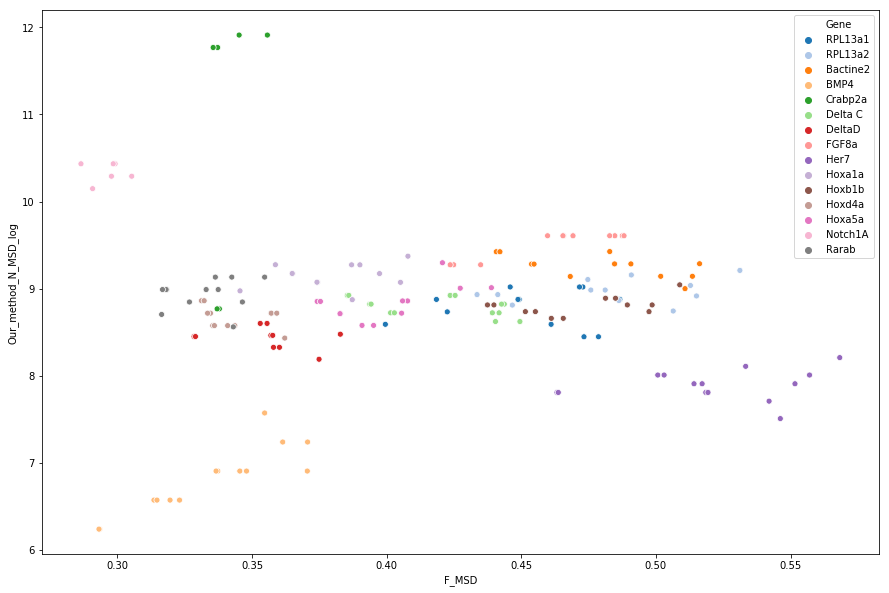

In [6]:
%matplotlib inline

def our_method_validation(dataset, precision):
    ''' Check the consistency of the inferred gene efficiencies on the validation dataset. '''

    # Computing the best validation point for each curve (max second derivative for now)
    dataset["MSD"] = dataset.apply(lambda row: qPCR_functions.area_under_chord_pd(row.Fluo)[1], axis=1)
    print(dataset.shape)
    #dataset.to_csv("/users/biocomp/bahin/na.tsv", sep="\t")
    dataset = dataset.dropna()
    #dataset.to_csv("/users/biocomp/bahin/na2.tsv", sep="\t")
    print(dataset.shape)
    # Getting the fluo value at this point
    dataset["F_MSD"] = dataset.apply(lambda row: row.Fluo[int(row["MSD"])], axis=1)
    # Computing the expected molecule number at this point
    dataset["Our_method_N_MSD"] = dataset.apply(lambda row: row.Theoretical_N0 * np.power(1 + methods_comparison.loc[row.Gene, "Our_method_" + precision + "_Ct"], row["MSD"]), axis=1)
    # Computing the log10 of the expected molecule number at this point
    dataset["Our_method_N_MSD_log"] = dataset.apply(lambda row: np.log10(row.Our_method_N_MSD), axis=1)

    # Plotting the correlation between Ft and Nt (logged)
    display(dataset.head(2))
    display(dataset.columns)
    dataset["Dilution_letters"] = dataset.apply(lambda row: "D" + str(row.Dilution), axis=1)
    plt.figure(figsize=(15, 10))
    hue_order = ["BMP4", "DeltaD", "Notch1A", "Her7", "Crabp2a", "Hoxa1a", "Hoxd4a", "RPL13a1",
                 "RPL13a2", "FGF8a", "Rarab", "Hoxb1b", "Hoxa5a", "Delta C", "Bactine2"]
    #ax = sns.scatterplot(x="F_MSD", y="Our_method_N_MSD_log", data=dataset.loc[dataset.S_or_C == "PS"], hue="Gene", hue_order=hue_order, palette="RdBu")
    ax = sns.scatterplot(x="F_MSD", y="Our_method_N_MSD_log", data=dataset.loc[dataset.S_or_C == "PC"], hue="Gene", palette="tab20")
    #plt.ylim(ymin=1e5, ymax=1e9)
    #plt.savefig("/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/our_method.validation." + precision + ".png")

# Validating the inferred gene efficiencies
our_method_validation(validation_dataset, "int")

In [2]:
### Defining useful variables
genes = ["BMP4", "Bactine2", "Crabp2a", "Delta C", "DeltaD", "FGF8a", "Her7", "Hoxa1a",
         "Hoxa5a", "Hoxb1b", "Hoxd4a", "Notch1A", "RPL13a1", "RPL13a2", "Rarab"]
not_preamplified = ["S01", "S02", "S03", "S04", "S05", "S06", "S07", "S08", "S09", "S10", "S11", "S49", "S50", "S51", "S52", "S53", "S54", "S55", "S56", "S57", "S58", "S59"]
#data_not_preamp = data.loc[(data.Sample.isin(not_preamplified)) & (data.Cycle_fluo_threshold_int.notnull())]
#data_not_preamp = data.loc[data.Sample.isin(not_preamplified)]
PS = ["S01", "S02", "S03", "S04", "S05", "S06", "S07", "S08", "S09", "S10", "S11"]
#data_PS = data.loc[(data.Sample.isin(PS)) & (data.Cycle_fluo_threshold_int.notnull())]
#data_PS = data.loc[data.Sample.isin(PS)]
PC = ["S49", "S50", "S51", "S52", "S53", "S54", "S55", "S56", "S57", "S58", "S59"]
#data_PC = data.loc[(data.Sample.isin(PC)) & (data.Cycle_fluo_threshold_int.notnull())]
#data_PC = data.loc[data.Sample.isin(PC)]

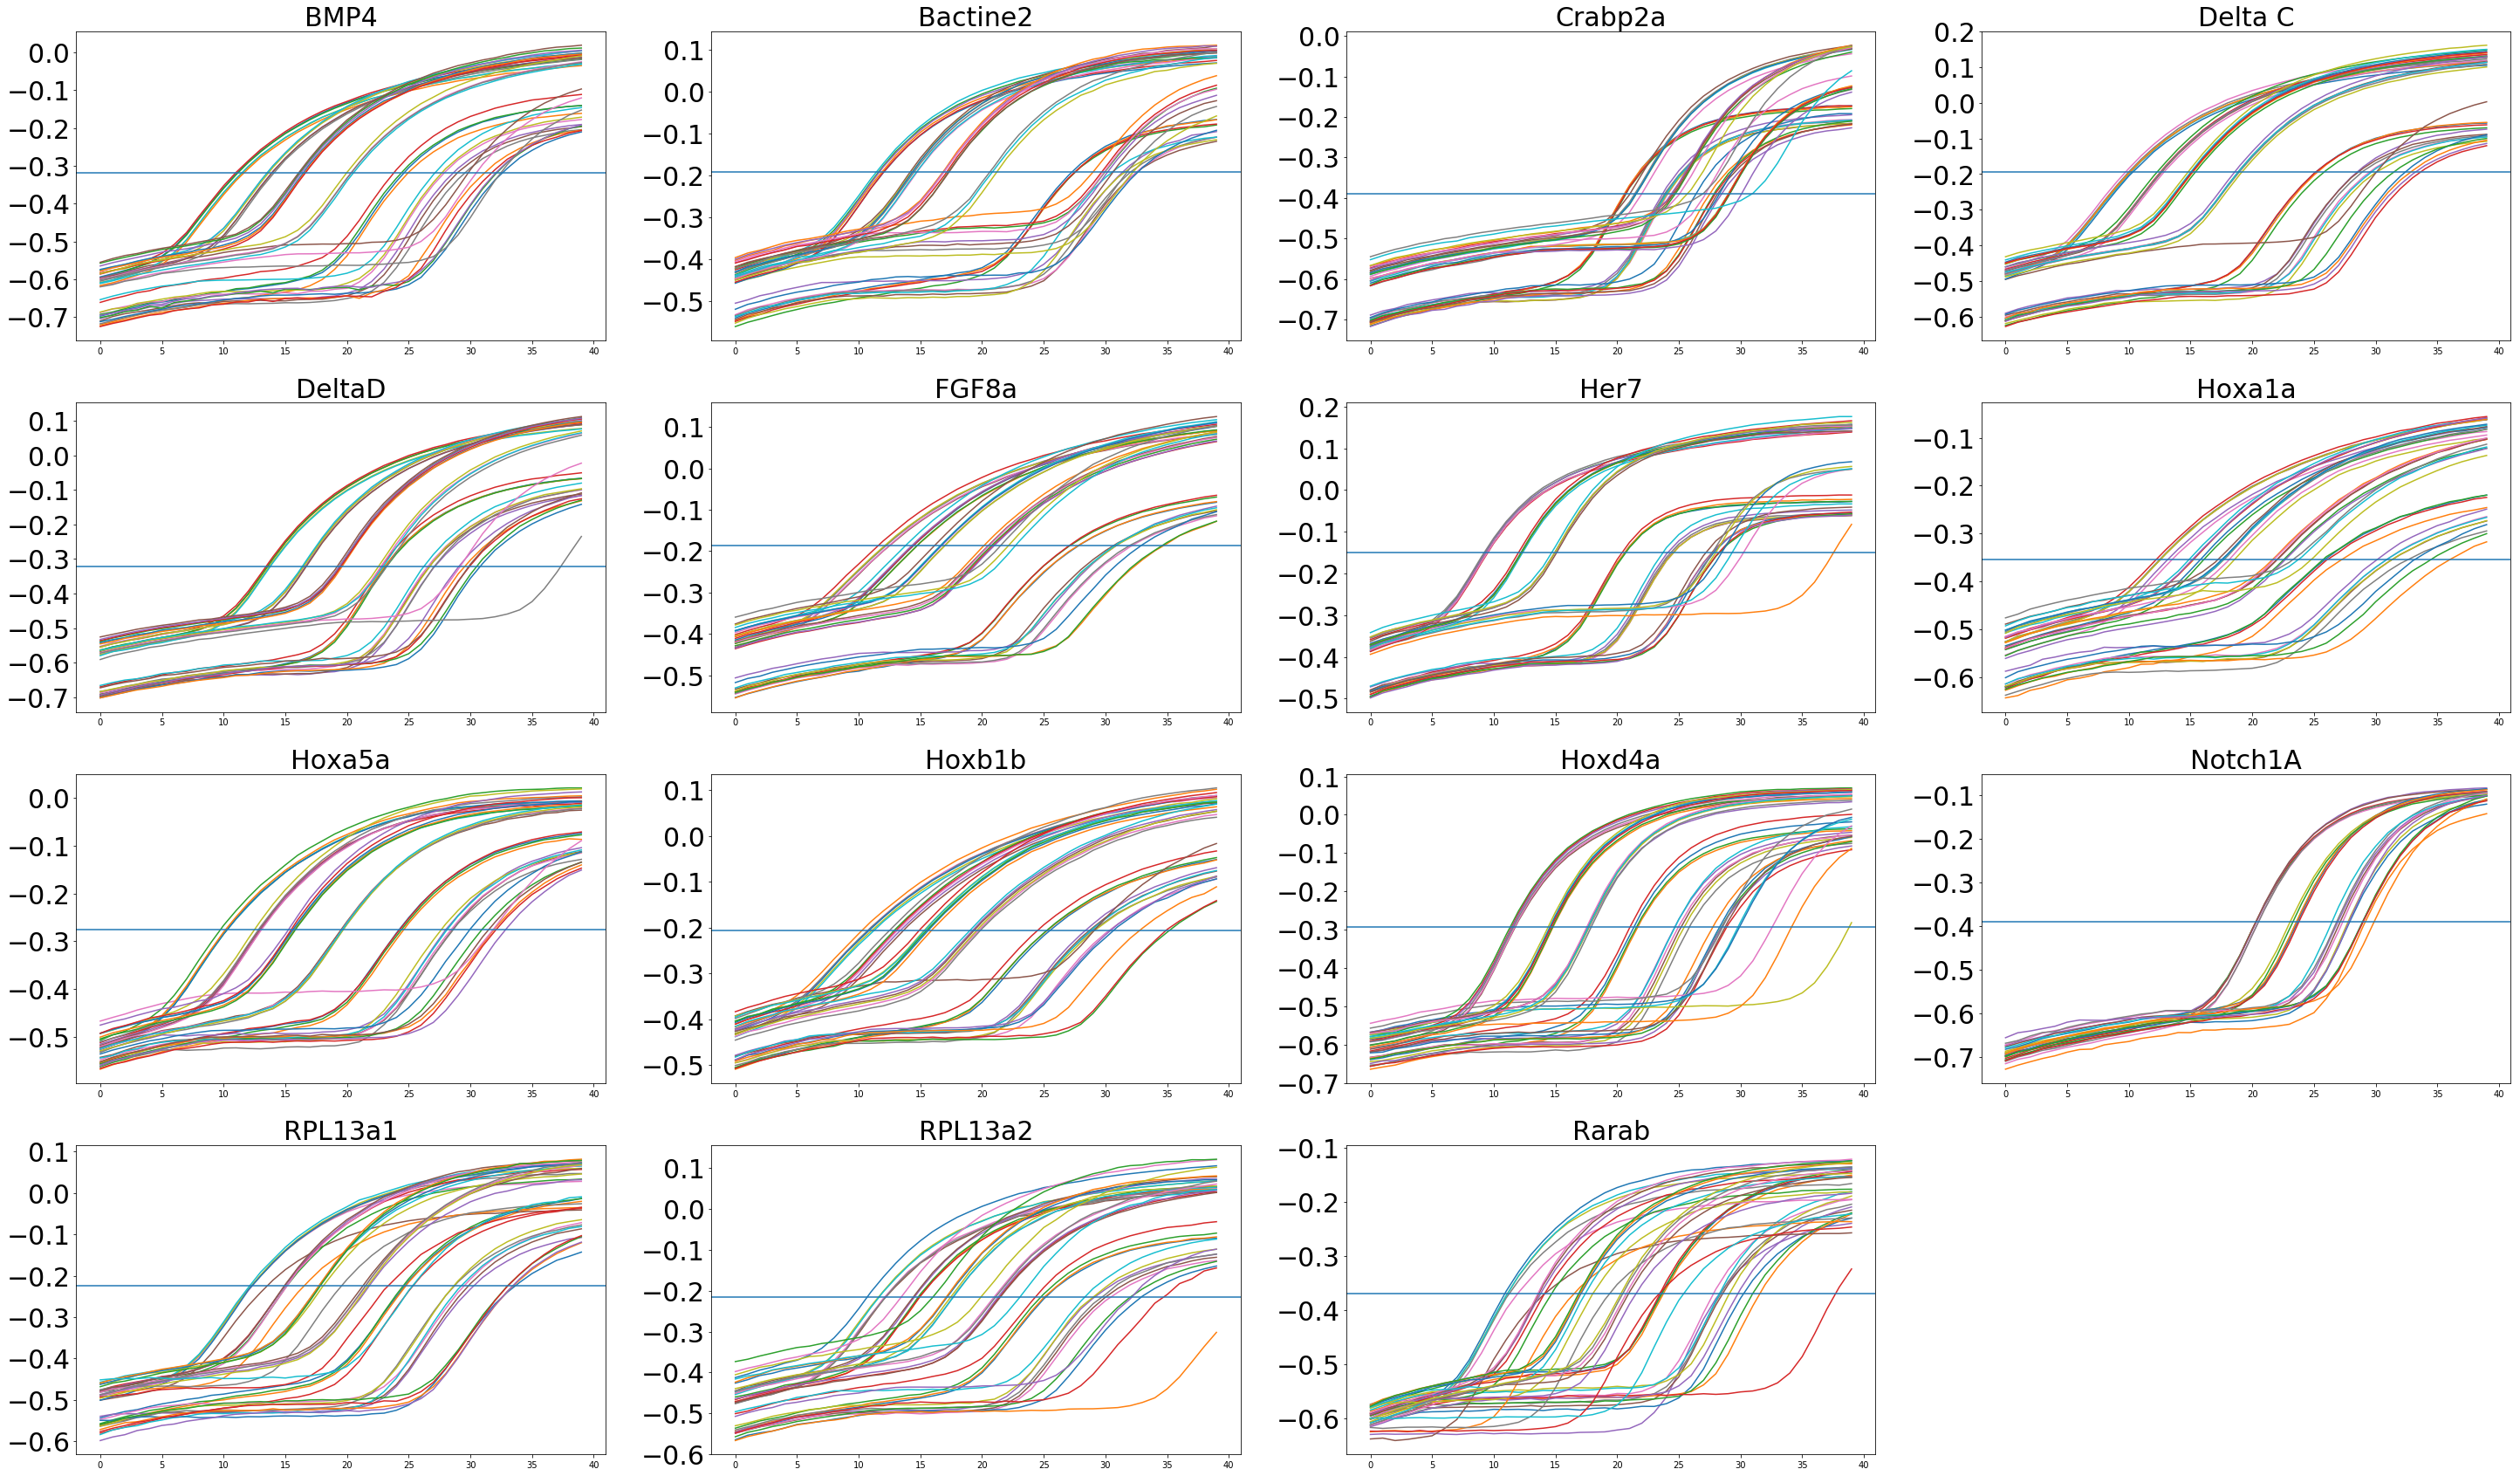

In [26]:
### Displaying (logged) fluo values per gene
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
os.chdir("/data/biocomp/bahin/qPCR/qPCRquantification/")
import fluo_quantity_relationship
%matplotlib inline

# Defining the dataset
dataset = data_not_preamp
measure = "Fluo_log"

# Displaying the curves
fig = plt.figure(figsize=(50, 30))
for gene, nb_plot in zip(genes, range(1, 16)):
    ax = plt.subplot(4, 4, nb_plot)
    for curve in dataset.loc[dataset.Gene == gene, measure].index[20:60]:
        ax.plot(dataset[measure][curve])
    ax.axhline(y=dataset.loc[dataset.Gene == gene, "Gene_fluo_log_median_pt"].iloc[0])
    plt.title(gene, fontdict={"fontsize": 30})
    plt.yticks(fontsize=30)

(1120, 22)
(1075, 22)


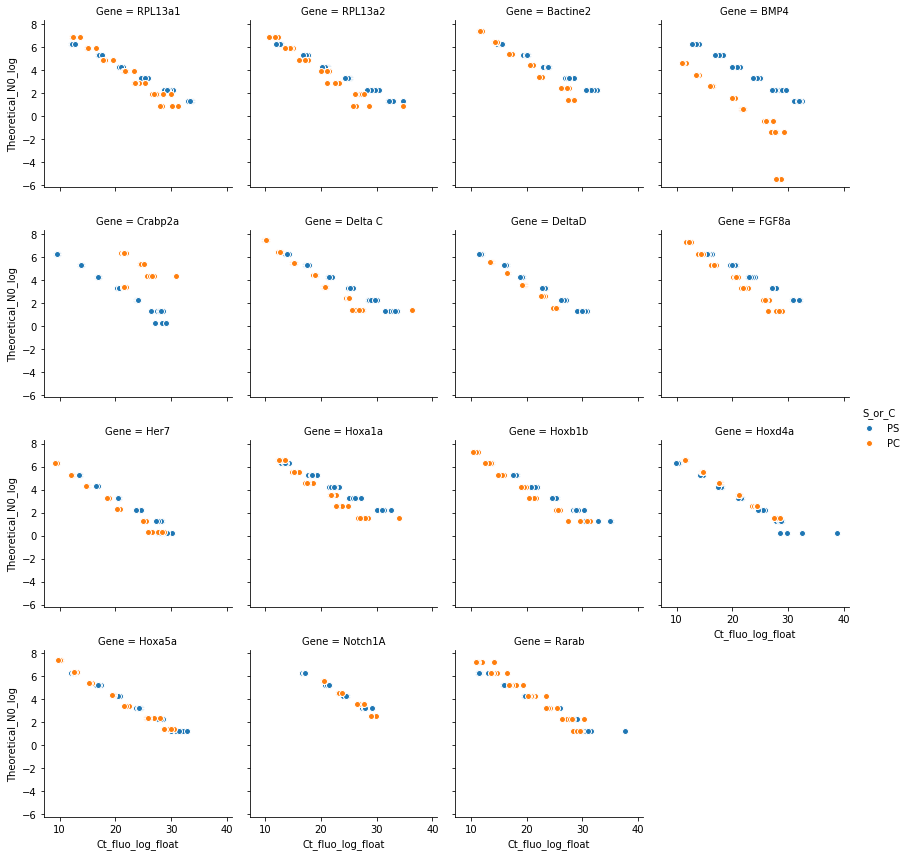

In [25]:
### Plotting Ct vs. Log(N0) for each gene
import seaborn as sns
os.chdir("/data/biocomp/bahin/qPCR/qPCRquantification/")
import fluo_quantity_relationship
%matplotlib inline

# Defining the dataset
dataset = data_not_preamp
print(dataset.shape)
dataset = dataset.groupby(["Gene", "Sample"]).filter(lambda row: row["WellID"].count() > 3)
print(dataset.shape)

# Plotting
g = sns.FacetGrid(dataset, col="Gene",  hue="S_or_C", col_wrap=4)
g = (g.map(plt.scatter, "Ct_fluo_log_float", "Theoretical_N0_log", edgecolor="w").add_legend())

,WellID,Condition,Gene,Fluidigm_Ct,Sample,Assay,Fluo,Amplitude,Pre_amplification,S_or_C,Dilution
0,S01-A01,PS1,RPL13a1,8.491106,S01,A01,"[0.37047587131367293, 0.3752927400468384, 0.37...",0.748706,0,PS,1
1,S01-A02,PS1,RPL13a1,8.375671,S01,A02,"[0.3514369012911287, 0.35948692320506415, 0.36...",0.819570,0,PS,1
2,S01-A03,PS1,RPL13a1,8.264054,S01,A03,"[0.36649389734158166, 0.37183333333333335, 0.3...",0.858508,0,PS,1
3,S01-A04,PS1,RPL13a1,8.359864,S01,A04,"[0.349412441449585, 0.3568437474341079, 0.3631...",0.851341,0,PS,1
4,S01-A05,PS1,RPL13a1,8.432876,S01,A05,"[0.3463741227716383, 0.3538039974210187, 0.358...",0.856313,0,PS,1


Slope: nan
Efficiency: nan
Intercept: nan


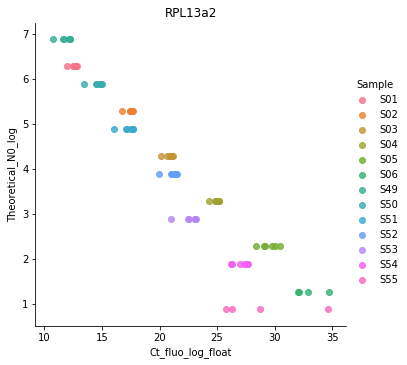

In [2]:
### Plotting Ct vs. Log(N0) for one gene
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
os.chdir("/data/biocomp/bahin/qPCR/qPCRquantification/")
import fluo_quantity_relationship
%matplotlib inline

# Defining the dataset
gene = "RPL13a2"
dataset = data_not_preamp.loc[(data_not_preamp.Gene == gene)]
display(data.head())
#dataset = dataset.groupby("Sample").filter(lambda row: row["WellID"].count() > 3)
#dataset = data_not_preamp.loc[(data_not_preamp.Gene == gene) & (data_not_preamp.Sample != "S11") & (data_not_preamp.Sample != "S59")]
#dataset = data_not_preamp.loc[(data_not_preamp.Gene == gene) & (data_not_preamp.Sample != "S57")]
#dataset = data_PC.loc[data_PC.Gene == gene]
#display(dataset.loc[(dataset.Gene == gene) & (dataset.Sample == "S11")])

# Plotting
sns.lmplot(x="Ct_fluo_log_float", y="Theoretical_N0_log", hue="Sample", data=dataset, fit_reg=False)
plt.title(gene)

# Computing the slope and intercept
slope, intercept, r_value, p_value, std_err = stats.linregress(dataset["Ct_fluo_log_float"], dataset["Theoretical_N0_log"])
print("Slope:", slope)
print("Efficiency:", np.power(10, -slope) - 1)
print("Intercept:", intercept)

In [45]:
### Plotting curves (mean curve for the 6 replicates) per sample
import seaborn as sns
import pandas as pd
%matplotlib inline

def write_fluo(row):
    global fluo_per_cycle
    for i, f in zip(range(40), row.Fluo_values):
        fluo_per_cycle = fluo_per_cycle.append({"Gene": row.Gene, "Sample": row.Sample, "Assay": row.Assay, "Cycle": i, "Fluo": f}, ignore_index=True)

# Defining the dataset
#dataset = data_PS.loc[data_PS.Gene.isin(["BMP4", "Rarab"])]
dataset = data_not_preamp
col = "Fluo"

# Creating the fluo values DataFrame
melted = pd.melt(dataset, id_vars=["Gene", "Sample","Assay"], value_vars=col, value_name="Fluo_values")
display(melted.head())
fluo_per_cycle = pd.DataFrame(columns=["Gene", "Sample", "Assay", "Cycle", "Fluo"])
melted.apply(lambda row: write_fluo(row), axis=1)
display(fluo_per_cycle.head())

# Plotting 
g = sns.FacetGrid(fluo_per_cycle, col="Gene",  hue="Sample", col_wrap=4)
g = (g.map(sns.lineplot, "Cycle", "Fluo", ci=None).add_legend())

NameError: name 'data_not_preamp' is not defined

,Assay,Cycle,Fluo,Gene,Sample
0,A1,0,2,G1,S1
1,A1,1,3,G1,S1
2,A1,2,4,G1,S1
3,A2,0,3,G1,S1
4,A2,1,4,G1,S1
5,A2,2,5,G1,S1
6,A3,0,1,G2,S2
7,A3,1,1,G2,S2
8,A3,2,3,G2,S2
9,A4,0,1,G2,S2


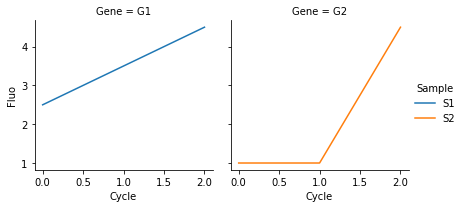

In [11]:
### Testing that sns.lineplot in FacetGrid (but it probably doesn't matter) average several values
df = pd.DataFrame({"Gene": ["G1", "G1", "G1", "G1", "G1", "G1", "G2", "G2", "G2", "G2", "G2", "G2"],
                  "Sample": ["S1", "S1", "S1", "S1", "S1", "S1", "S2", "S2", "S2", "S2", "S2", "S2"],
                  "Assay": ["A1", "A1", "A1", "A2", "A2", "A2", "A3", "A3", "A3", "A4", "A4", "A4"],
                  "Cycle": [0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2],
                  "Fluo": [2, 3, 4, 3, 4, 5, 1, 1, 3, 1, 1, 6]})
display(df)

g = sns.FacetGrid(df, col="Gene",  hue="Sample")
g = (g.map(sns.lineplot, "Cycle", "Fluo", ci=None).add_legend())

(-1.2, 6)

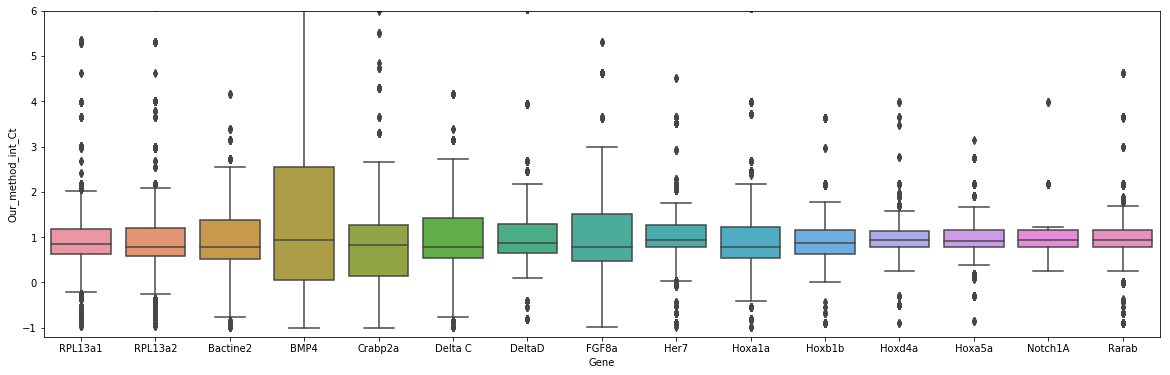

In [7]:
### Plotting the computed E distribution with "our method"
from matplotlib.pyplot import figure
import pandas as pd
%matplotlib inline

# Plotting
figure(figsize=(20, 6))
ax = sns.boxplot(x="Gene", y="Our_method_int_Ct", data=well_comb_filtered)
ax.set_ylim([-1.2, 6])

In [13]:
### Tracking weird efficiencies produced by "our" method
print well_comb_filtered.shape
#df = well_comb_filtered[(well_comb_filtered.Computed_E < 0) | (well_comb_filtered.Computed_E > 1)]
#df = well_comb_filtered[well_comb_filtered.Computed_E < 0]
df = well_comb_filtered[well_comb_filtered.Our_method_int_Ct > 1]
display(df[df.Condition_1 == "PC1"].groupby("Condition_2").size().sort_values())

(74944, 31)


Condition_2
PS9      18
PS8      18
PC9      24
PC8      24
PS11     30
PC11     30
PS6      75
PS4      79
PS5      85
PS7     120
PS3     155
PS1     181
PS2     186
PC7     275
PC6     380
PC4     424
PC5     470
PC3     486
PC2     503
dtype: int64

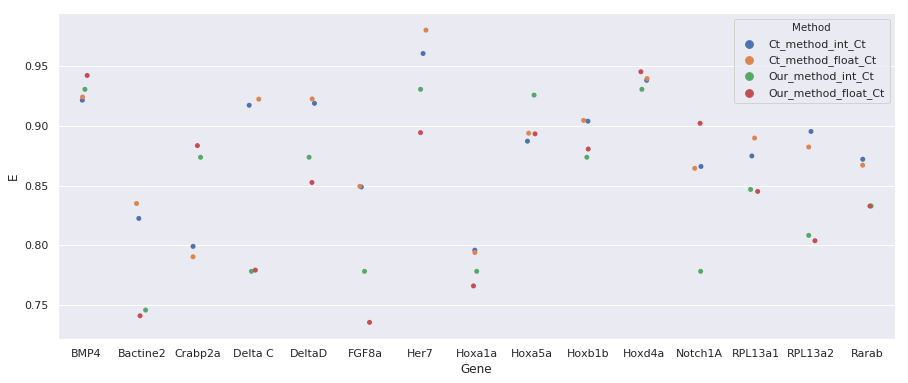

In [5]:
### Displaying the various computed efficiencies
import matplotlib as plt
import seaborn as sns
%matplotlib inline

# Pivoting DataFrame
methods_comparison["Gene"] = methods_comparison.index
pivoted = pd.melt(methods_comparison, id_vars=["Gene"], var_name="Method", value_name="E")

# Plotting the results
sns.set(rc={'figure.figsize':(15,6)})
sns.stripplot(x="Gene", y="E", data=pivoted, hue="Method")

In [21]:
### Plotting Ft/Nt per gene for our method
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
display(data_not_preamp.head())
data_not_preamp["Our_method_Nt_MSD_pt_log"] = data_not_preamp.apply(lambda row: np.log10(row.Our_method_Nt_MSD_pt), axis=1)

#dataset = data_preamp.groupby(["Gene", "Sample"]).filter(lambda row: row["WellID"].count() > 3)
#dataset = data_preamp
#dataset = pd.merge(data_preamp, data_not_preamp[["Gene", "Gene_fluo_median_pt"]], on="Gene")
#display(dataset.head(2))
#gene = "RPL13a1"
#data = data_preamp.loc[data_preamp.Gene == gene]
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x="Ft_MSD_pt", y="Our_method_N_MSD_pt_log", data=data_preamp, hue="Gene")
#ax = sns.scatterplot(x="Ft_well_median_pt", y="Nt_well_median_pt", data=data_preamp, hue="Gene")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.ylim(ymin=-100000, ymax = 80000000)

,WellID,Condition,Gene,Fluidigm_Ct,Sample,Assay,Fluo,Amplitude,Pre_amplification,S_or_C,Dilution,Theoretical_N0,Theoretical_N0_log,MSD,F_MSD,Fluo_log,Fluo_log_median_pt,Gene_fluo_log_median_pt,Ct_fluo_log_int,Ct_fluo_log_float
0,S01-A01,PS1,RPL13a1,8.491106,1,1,"[0.37047587131367293, 0.3752927400468384, 0.37...",0.748706,0,PS,1,1.879660e+06,6.274079,8,0.424798,"[-0.43124007188589847, -0.4256298368341689, -0...",-0.191170,-0.22349,12,12.442710
1,S01-A02,PS1,RPL13a1,8.375671,1,2,"[0.3514369012911287, 0.35948692320506415, 0.36...",0.819570,0,PS,1,1.879660e+06,6.274079,8,0.411649,"[-0.4541526390111651, -0.44431690300898197, -0...",-0.192797,-0.22349,12,12.356066
2,S01-A03,PS1,RPL13a1,8.264054,1,3,"[0.36649389734158166, 0.37183333333333335, 0.3...",0.858508,0,PS,1,1.879660e+06,6.274079,8,0.430934,"[-0.4359332525997755, -0.4296516800998059, -0....",-0.173898,-0.22349,12,12.021752
3,S01-A04,PS1,RPL13a1,8.359864,1,4,"[0.349412441449585, 0.3568437474341079, 0.3631...",0.851341,0,PS,1,1.879660e+06,6.274079,8,0.414364,"[-0.4566616352526176, -0.44752190848714063, -0...",-0.188604,-0.22349,12,12.311427
4,S01-A05,PS1,RPL13a1,8.432876,1,5,"[0.3463741227716383, 0.3538039974210187, 0.358...",0.856313,0,PS,1,1.879660e+06,6.274079,8,0.413342,"[-0.46045456110410166, -0.45123726456342717, -...",-0.190151,-0.22349,12,12.302796


AttributeError: ("'Series' object has no attribute 'Our_method_Nt_MSD_pt'", 'occurred at index 0')

,WellID,Condition,Gene,Fluidigm_Ct,Sample,Assay,Fluo,Amplitude,Pre_amplification,S_or_C,Dilution,Theoretical_N0,Max_second_derivative,Ft_MSD_pt,Our_method_Nt_MSD_pt,Our_method_Nt_MSD_pt_log
0,S13-A09,10C_PS8,RPL13a2,26.624677,13,9,"[0.32738305643926, 0.33495973193815765, 0.3394...",0.601547,10,PS,8,0.000772,26,0.449307,2440.023212,3.387394
1,S13-A10,10C_PS8,RPL13a2,25.669622,13,10,"[0.34203016714227474, 0.34810126582278483, 0.3...",0.649875,10,PS,8,0.000772,25,0.464699,1372.125887,3.137394


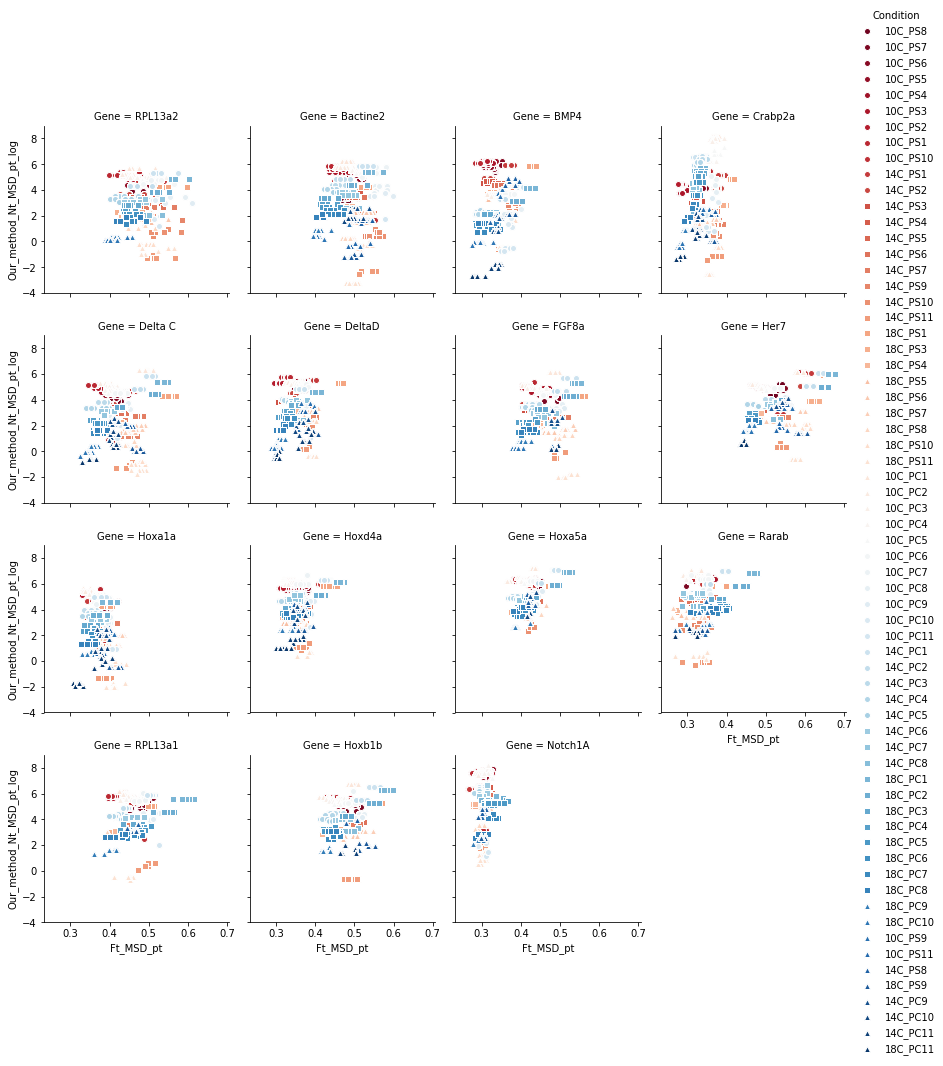

In [3]:
### Plotting Ft/Nt per gene for our method
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

display(data_preamp.head(2))
#display(data_not_preamp.head(2))

#data_preamp["Our_method_Nt_well_median_pt_log"] = data_preamp.apply(lambda row: np.log10(row.Our_method_Nt_well_median_pt), axis=1)
#data_preamp["Our_method_Nt_gene_median_pt_log"] = data_preamp.apply(lambda row: np.log10(row.Our_method_Nt_gene_median_pt), axis=1)
data_preamp["Our_method_Nt_MSD_pt_log"] = data_preamp.apply(lambda row: np.log10(row.Our_method_Nt_MSD_pt), axis=1)

#dataset = data_preamp.groupby(["Gene", "Sample"]).filter(lambda row: row["WellID"].count() > 3)
#dataset = data_preamp
dataset = pd.merge(data_preamp, data_not_preamp[["Gene", "Gene_fluo_median_pt"]], on="Gene")
#display(dataset.head(2))
#gene = "RPL13a1"
#data = data_preamp.loc[data_preamp.Gene == gene]
#plt.figure(figsize=(8, 6))
#ax = sns.scatterplot(x="Ft_well_median_pt", y="Our_methodNt_well_median_pt_log", data=data, hue="Condition")
#ax = sns.scatterplot(x="Ft_well_median_pt", y="Nt_well_median_pt", data=data_preamp, hue="Gene")
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.ylim(ymin=-100000, ymax = 80000000)


#g = sns.FacetGrid(dataset, col="Gene",  hue="Condition", col_wrap=4, sharex=False, sharey=False, palette="RdBu",
g = sns.FacetGrid(dataset, col="Gene",  hue="Condition", col_wrap=4, palette="RdBu",
                 hue_kws=dict(marker=["o", "o", "o", "o", "o", "o", "o", "o", "o", "o", "o",
                                      "s", "s", "s", "s", "s", "s", "s", "s", "s", "s", "s",
                                      "^", "^", "^", "^", "^", "^", "^", "^", "^", "^", "^",
                                      "o", "o", "o", "o", "o", "o", "o", "o", "o", "o", "o",
                                      "s", "s", "s", "s", "s", "s", "s", "s", "s", "s", "s",
                                      "^", "^", "^", "^", "^", "^", "^", "^", "^", "^", "^"]))

"""
g = sns.FacetGrid(data_preamp, col="Gene",  hue="Condition", col_wrap=4, sharex=False, sharey=False, palette="RdBu",
                  hue_kws=dict(marker=["x", "<", "P", "^", "s", "1", "v", "o", ">", "D", "_",
                                       "o", "v", "1", "s", "^", "P", "<", "x", ">", "D", "_",
                                       "o", "1", "s", "^", "P", "<", "x", ">", "D", "_",
                                       "o", "v", "1", "s", "^", "P", "<", "x", ">", "D", "_",
                                       "o", "v", "1", "s", "^", "P", "<", "x", ">", "D", "_",
                                       "o", "v", "1", "s", "^", "P", "<", "x", ">", "D", "_"]))
g = (g.map(plt.scatter, "Ft_well_median_pt", "Nt_well_median_pt", edgecolor="w").add_legend())
"""
#g = (g.map(plt.scatter, "Ft_well_median_pt", "Our_method_Nt_well_median_pt_log", edgecolor="w").add_legend())
#g = (g.map(plt.scatter, "Ft_gene_median_pt", "Our_method_Nt_gene_median_pt_log", edgecolor="w").add_legend())
g = (g.map(plt.scatter, "Ft_MSD_pt", "Our_method_Nt_MSD_pt_log", edgecolor="w").add_legend())

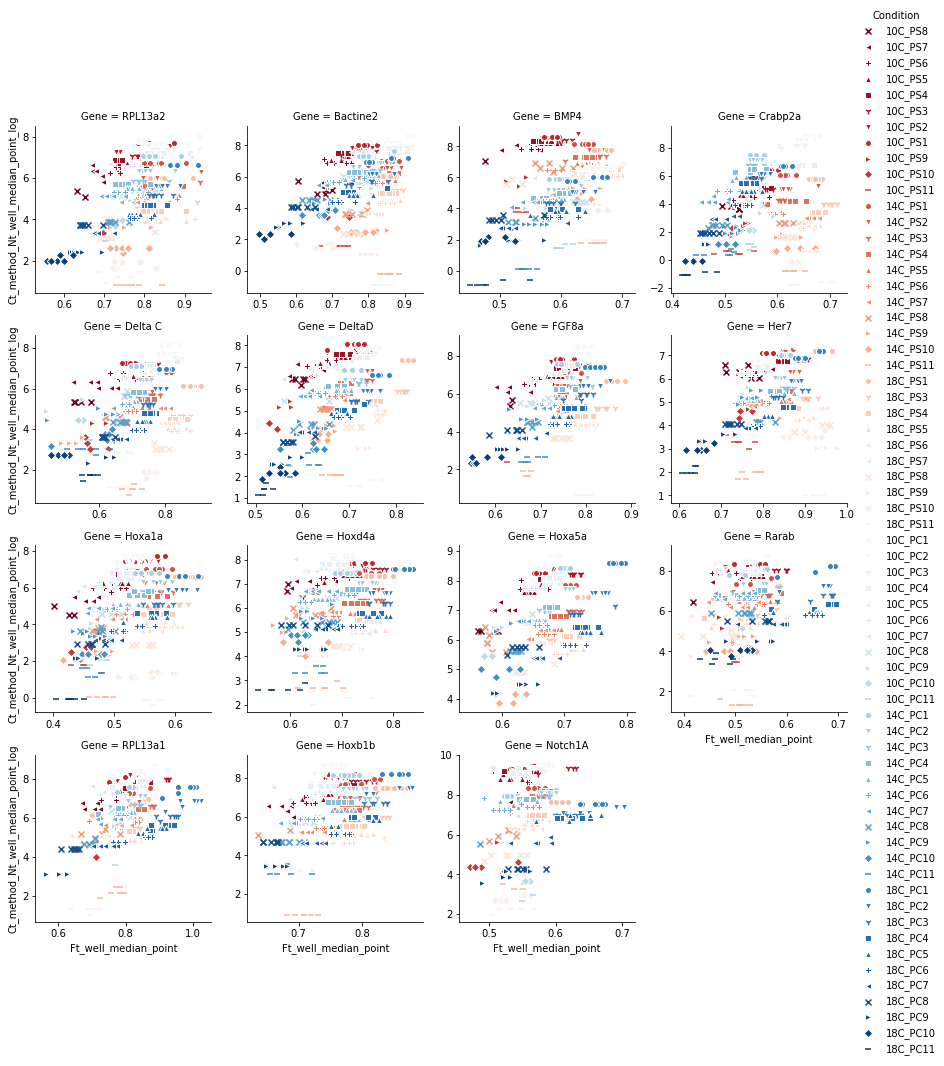

In [6]:
### Plotting Ft/Nt per gene for Ct method
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

data_preamp["Ct_method_Nt_well_median_pt_log"] = data_preamp.apply(lambda row: np.log10(row.Ct_method_Nt_well_median_pt), axis=1)
g = sns.FacetGrid(data_preamp, col="Gene",  hue="Condition", col_wrap=4, sharex=False, sharey=False, palette="RdBu",
                  hue_kws=dict(marker=["x", "<", "P", "^", "s", "1", "v", "o", ">", "D", "_",
                                       "o", "v", "1", "s", "^", "P", "<", "x", ">", "D", "_",
                                       "o", "1", "s", "^", "P", "<", "x", ">", "D", "_",
                                       "o", "v", "1", "s", "^", "P", "<", "x", ">", "D", "_",
                                       "o", "v", "1", "s", "^", "P", "<", "x", ">", "D", "_",
                                       "o", "v", "1", "s", "^", "P", "<", "x", ">", "D", "_"]))
#g = (g.map(plt.scatter, "Ft_well_median_pt", "Nt_well_median_pt", edgecolor="w").add_legend())
g = (g.map(plt.scatter, "Ft_well_median_pt", "Ct_method_Nt_well_median_pt_log", edgecolor="w").add_legend())

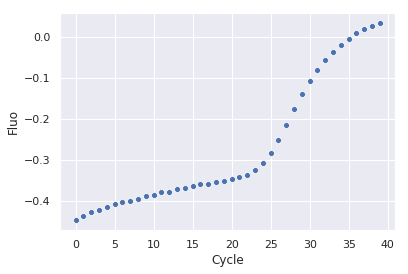

In [49]:
## Plotting one curve
sample = 54
assay = 8

sns.scatterplot(x="Cycle", y="Fluo", data=fluo_per_cycle.loc[(fluo_per_cycle["Sample"] == sample) &
                                                             (fluo_per_cycle["Assay"] == assay)])

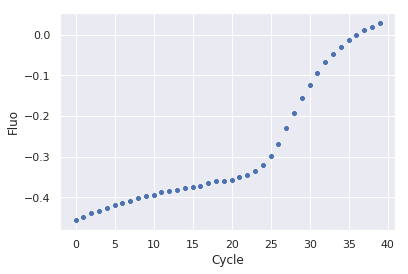

In [48]:
## Plotting one curve
sample = 54
assay = 9

sns.scatterplot(x="Cycle", y="Fluo", data=fluo_per_cycle.loc[(fluo_per_cycle["Sample"] == sample) &
                                                             (fluo_per_cycle["Assay"] == assay)])

In [44]:
## Plotting several curves
gene = "BMP4"
sample = 10
display(fluo_per_cycle.head(2))
to_plot = fluo_per_cycle.loc[(fluo_per_cycle["Gene"] == gene) & (fluo_per_cycle["Sample"] == sample)]
to_plot["Assay_letters"] = to_plot.apply(lambda row: "A" + str(row["Assay"]), axis=1)

sns.scatterplot(x="Cycle", y="Fluo", data=to_plot, hue="Assay_letters")

NameError: name 'fluo_per_cycle' is not defined

In [10]:
## Plotting 5-6 replicates curves
col = "Fluo_normalized_F0"
validation_dataset = data_not_preamp.loc[(data_not_preamp["Assay"] - 1) % 6 >= 4]
validation_dataset["Assay_letters"] = validation_dataset.apply(lambda row: "A" + str(row["Assay"]), axis=1)

# Creating the fluo values DataFrame
melted = pd.melt(validation_dataset, id_vars=["Gene", "Sample","Assay"], value_vars=col, value_name="Fluo_values")
fluo_per_cycle = pd.DataFrame(columns=["Gene", "Sample", "Assay", "Cycle", "Fluo"])
melted.apply(lambda row: write_fluo(row), axis=1)
display(fluo_per_cycle.head())

# Plotting 
g = sns.FacetGrid(fluo_per_cycle, col="Gene",  hue="Sample", col_wrap=4, palette="RdBu")
g = (g.map(sns.lineplot, "Cycle", "Fluo", ci=None).add_legend())

TypeError: ('zip argument #2 must support iteration', 'occurred at index 0')

In [64]:
import pandas as pd
nb_well=9216
df = pd.read_csv("/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/1362243513_fixed_HiFitMB.csv", usecols=[0, 1, 4, 6], skiprows=1, nrows=nb_well, names=["WellID", "Condition", "Gene", "Fluidigm_Ct"])
# Splitting the well ID into sample and assay info
df["Sample"] = df.apply(lambda row: int(row.WellID[1:3]), axis=1)
df["Assay"] = df.apply(lambda row: int(row.WellID[5:]), axis=1)
# Getting the fluo values
F = pd.read_csv("/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/1362243513_fixed_HiFitMB.csv", skiprows=nb_well+4, header=None, sep="\t", names=["Fluo"])
F0 = pd.read_csv("/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/1362243513_fixed_HiFitMB.csv", usecols=[0], skiprows=nb_well+4, header=None, sep=",", names=["F0"])
# Concatenating well info and fluo values
df = pd.concat([df, F, F0], axis=1)
# Computing genes mean F0
F0_gene_mean = df.groupby("Gene")["F0"].agg(np.mean).to_frame(name="F0_gene_mean")
df = df.merge(F0_gene_mean, on=["Gene"])
# Creating normalized F0 fluo values
df["Fluo_normalized_F0"] = df.apply(lambda x: [float(val) + x.F0_gene_mean - x.F0 for val in x.Fluo.split(",")], axis=1)
# Changing fluo values type to float
df["Fluo"] = df["Fluo"].apply(lambda x: [float(val) for val in x.split(",")])

display(df.head())

,WellID,Condition,Gene,Fluidigm_Ct,Sample,Assay,Fluo,F0,F0_gene_mean
0,S01-A01,PS1,RPL13a1,8.491106,1,1,"3.704758713136729331e-01,3.752927400468383801e...",0.370476,0.358704
1,S01-A02,PS1,RPL13a1,8.375671,1,2,"3.514369012911287005e-01,3.594869232050641461e...",0.351437,0.358704
2,S01-A03,PS1,RPL13a1,8.264054,1,3,"3.664938973415816648e-01,3.718333333333333490e...",0.366494,0.358704
3,S01-A04,PS1,RPL13a1,8.359864,1,4,"3.494124414495849984e-01,3.568437474341079052e...",0.349412,0.358704
4,S01-A05,PS1,RPL13a1,8.432876,1,5,"3.463741227716383153e-01,3.538039974210187011e...",0.346374,0.358704


,WellID,Condition,Gene,Fluidigm_Ct,Sample,Assay,Fluo,F0,F0_gene_mean,Fluo_normalized_F0
0,S01-A01,PS1,RPL13a1,8.491106,1,1,"[0.37047587131367293, 0.3752927400468384, 0.37...",0.370476,0.358704,"[0.3587039590516292, 0.36352082778479455, 0.36..."
1,S01-A02,PS1,RPL13a1,8.375671,1,2,"[0.3514369012911287, 0.35948692320506415, 0.36...",0.351437,0.358704,"[0.3587039590516291, 0.36675398096556455, 0.37..."
2,S01-A03,PS1,RPL13a1,8.264054,1,3,"[0.36649389734158166, 0.37183333333333335, 0.3...",0.366494,0.358704,"[0.35870395905162905, 0.36404339504338074, 0.3..."
3,S01-A04,PS1,RPL13a1,8.359864,1,4,"[0.349412441449585, 0.3568437474341079, 0.3631...",0.349412,0.358704,"[0.3587039590516292, 0.366135265036152, 0.3724..."
4,S01-A05,PS1,RPL13a1,8.432876,1,5,"[0.3463741227716383, 0.3538039974210187, 0.358...",0.346374,0.358704,"[0.358703959051629, 0.3661338337010094, 0.3713..."
